This notebook is used to play around the JAX-CANOAK model.

# Load the necessary libraries

In [1]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [3]:
import jax
import equinox as eqx

# from functools import partial

# import numpy as np
# import jax.numpy as jnp

# import jax.tree_util as jtu

from jax_canoak.subjects import get_met_forcings, initialize_parameters
from jax_canoak.physics.energy_fluxes import get_dispersion_matrix
from jax_canoak.models import canoak, CanoakBase

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import plot_daily
from jax_canoak.shared_utilities.plot import (
    # plot_timeseries,
    # plot_temp,
    # plot_imshow,
    plot_imshow2,
)


# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_debug_infs", False)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model parameters and settings

In [4]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 2
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
meas_ht = 5.0
n_hr_per_day = 48
lai = 5.0
niter = 15
f_forcing = "../data/fluxtower/Alf/AlfBouldinMetInput-yr.csv"

# Load and set the model forcings

In [5]:
met, n_time = get_met_forcings(f_forcing, lai)

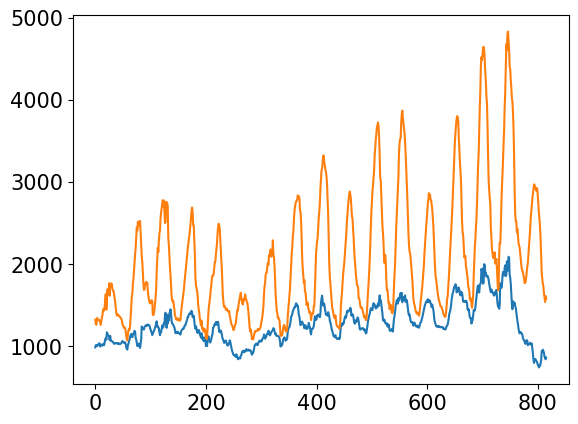

In [6]:
plt.plot(met.eair_Pa)
plt.plot(met.es)

# Create the model parameter instance

In [7]:
setup, para = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    meas_ht=meas_ht,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    niter=niter,
)

# Generate or read the dispersion matrix

In [8]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, para, "../data/dij/Dij_Alfalfa.csv")

# Create the model instance

In [9]:
canoak_eqx = CanoakBase(para, setup, dij)

# Benchmark the computing time of CANOAK

## GPU

In [12]:
# On GPU, jitted
%timeit canoak_eqx(met)

296 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# On GPU, jitted, function-based
canoak_jit = eqx.filter_jit(canoak)
%timeit canoak_jit(para, setup, met, dij, setup.soil_mtime, setup.niter)

297 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# On GPU, unjitted, function-based
%timeit canoak(para, setup, met, dij, setup.soil_mtime, setup.niter)

5.43 s ± 80.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## CPU

In [23]:
para_cpu = jax.device_put(para, device=jax.devices("cpu")[0])
# setup_cpu = jax.device_put(setup, device=jax.devices("cpu")[0])
met_cpu = jax.device_put(met, device=jax.devices("cpu")[0])
dij_cpu = jax.device_put(dij, device=jax.devices("cpu")[0])

In [41]:
# On CPU, jitted
canoak_jit = eqx.filter_jit(canoak)
%timeit canoak_jit(para_cpu, setup, met_cpu, dij_cpu, setup.soil_mtime, setup.niter)

840 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
# On CPU, unjitted
%timeit canoak(para_cpu, setup, met_cpu, dij_cpu, setup.soil_mtime, setup.niter)

7.14 s ± 72.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Run CANOAK!

In [10]:
jax.clear_caches()
canoak_eqx = CanoakBase(para, setup, dij)
(
    _,
    prof,
    quantum,
    nir,
    ir,
    rnet,
    qin,
    sun_ang,
    leaf_ang,
    lai,
    sun,
    shade,
    soil,
    veg,
    can,
) = canoak_eqx(met)

In [39]:
# jax.clear_caches()
# other_args = [
#     dij, setup.lat_deg, setup.long_deg, setup.time_zone,
#     setup.leafangle, setup.stomata,
#     setup.n_can_layers, setup.n_total_layers, setup.n_soil_layers,
#     setup.ntime, setup.dt_soil,
#     setup.soil_mtime, setup.niter
# ]
# # canoak_jit = eqx.filter_jit(canoak)
# (
#     met,
#     prof,
#     quantum,
#     nir,
#     ir,
#     rnet,
#     qin,
#     sun_ang,
#     leaf_ang,
#     lai,
#     sun,
#     shade,
#     soil,
#     veg,
#     can,
# ) = canoak(para, met, *other_args)

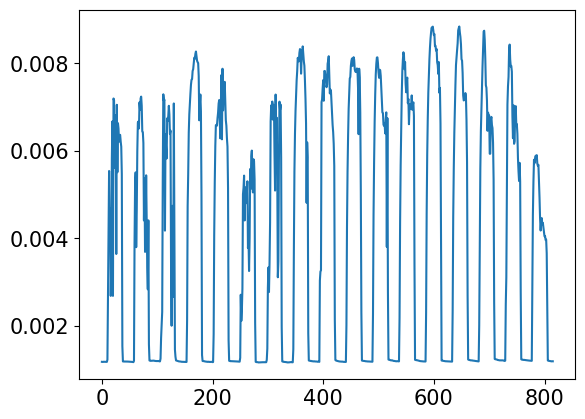

In [11]:
# plt.plot(qin.sun_abs);
plt.plot(sun.gs.mean(axis=1));

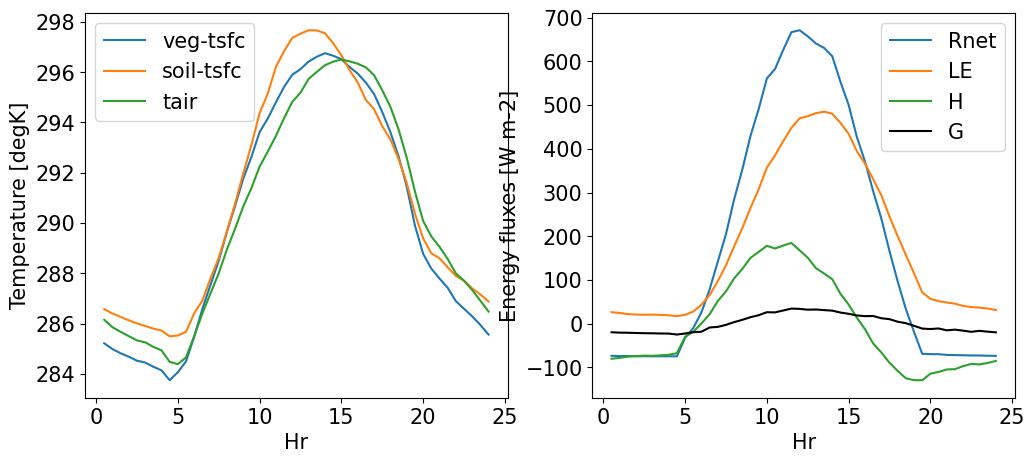

In [36]:
# Daily average
plot_daily(met, soil, veg, para);

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0), met.hhour)
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0), met.hhour)
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0), met.hhour)


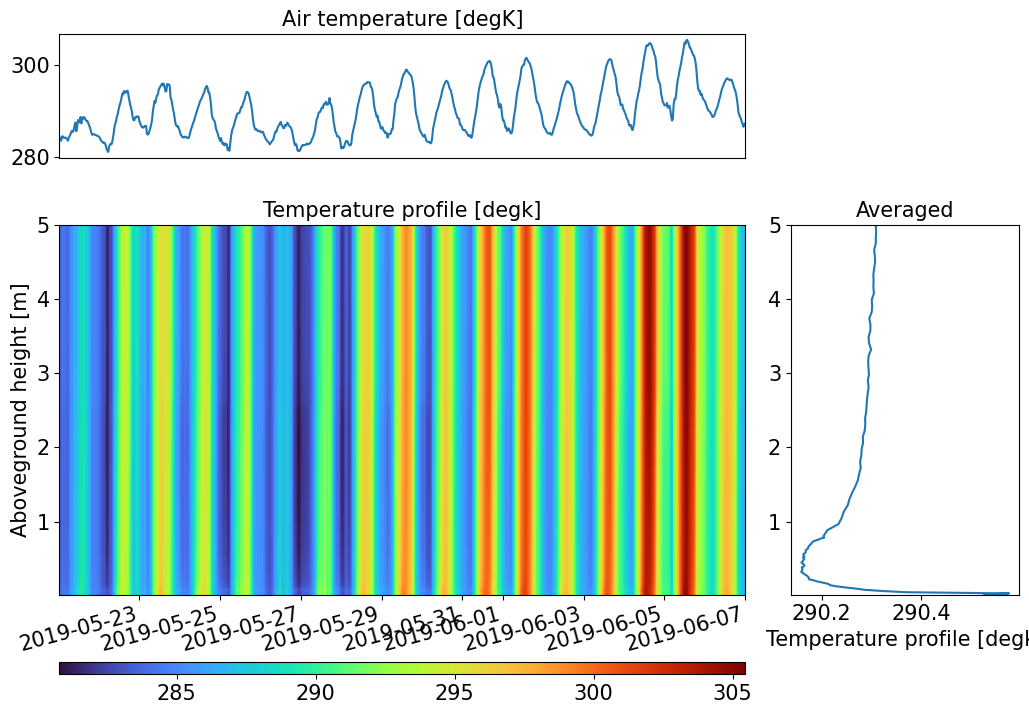

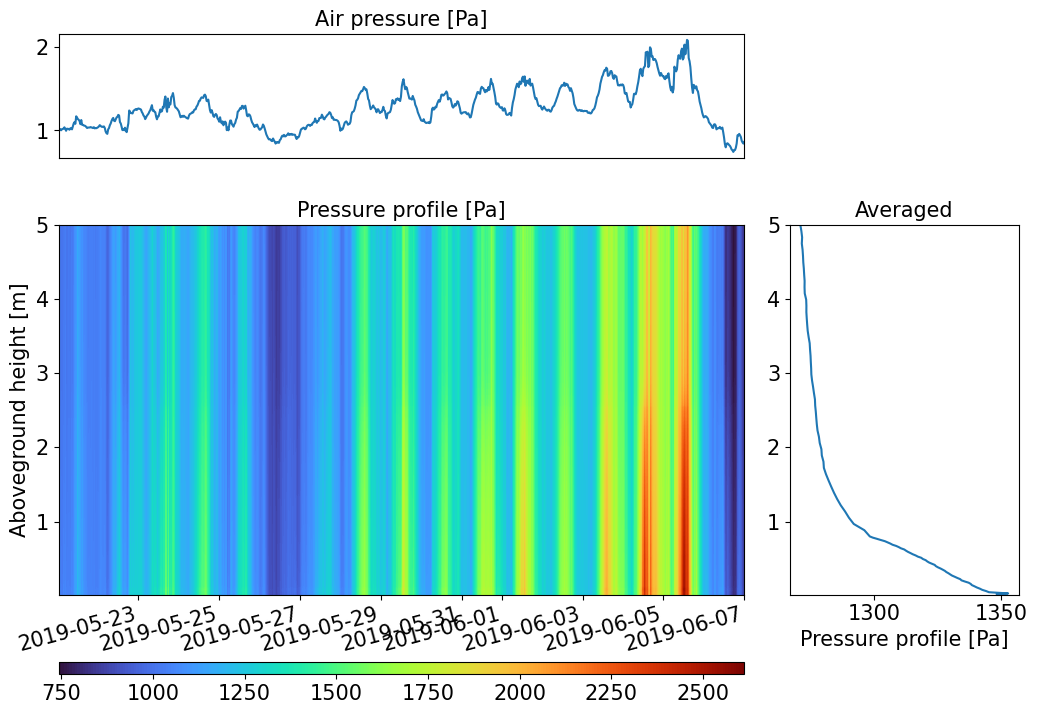

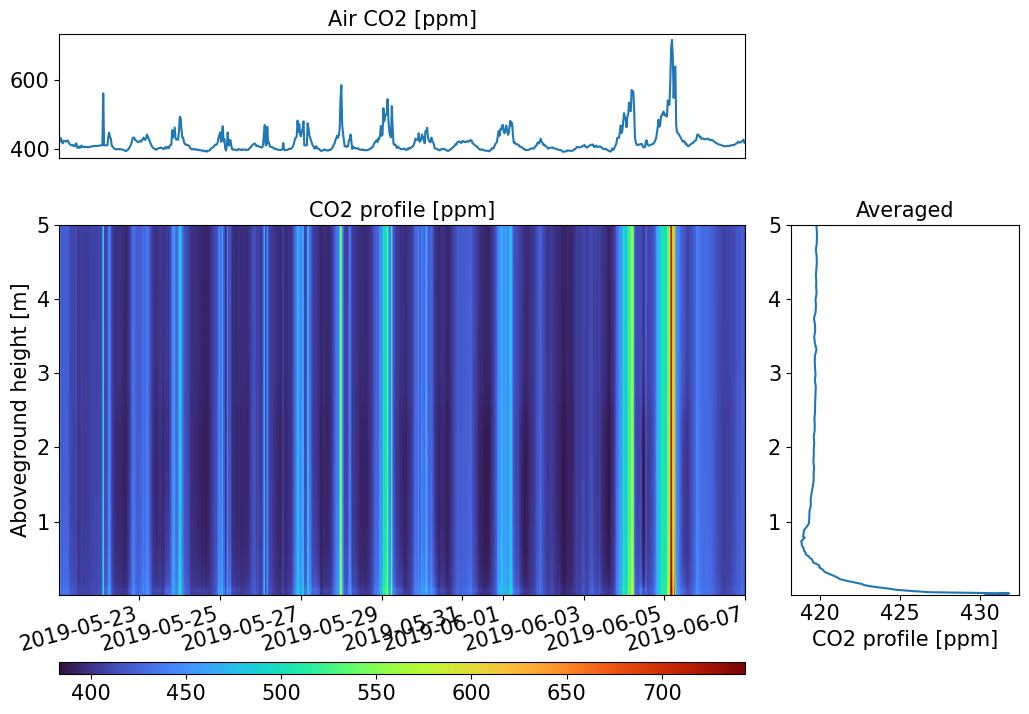

In [32]:
# Profiles
plot_imshow2(
    prof.Tair_K.T,
    met,
    para.zht,
    key="T",
    title="Temperature profile [degk]",
    cmap="turbo",
)
plot_imshow2(
    prof.eair_Pa.T, met, para.zht, key="e", title="Pressure profile [Pa]", cmap="turbo"
)
plot_imshow2(
    prof.co2.T, met, para.zht, key="co2", title="CO2 profile [ppm]", cmap="turbo"
)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0), met.hhour)
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0), met.hhour)
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0), met.hhour)


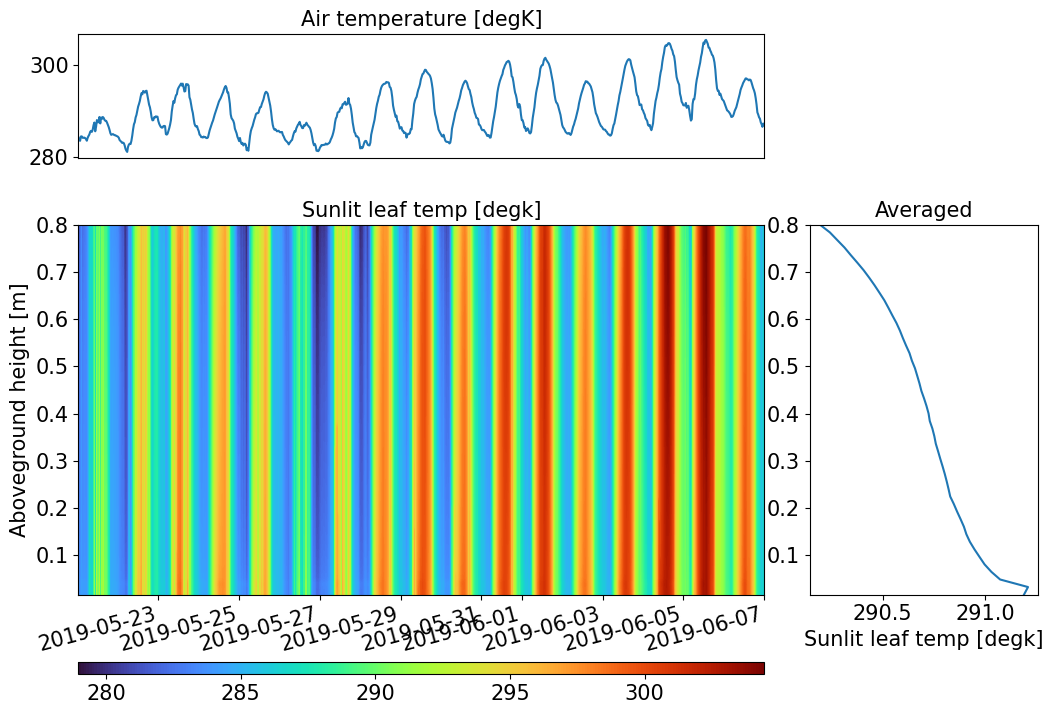

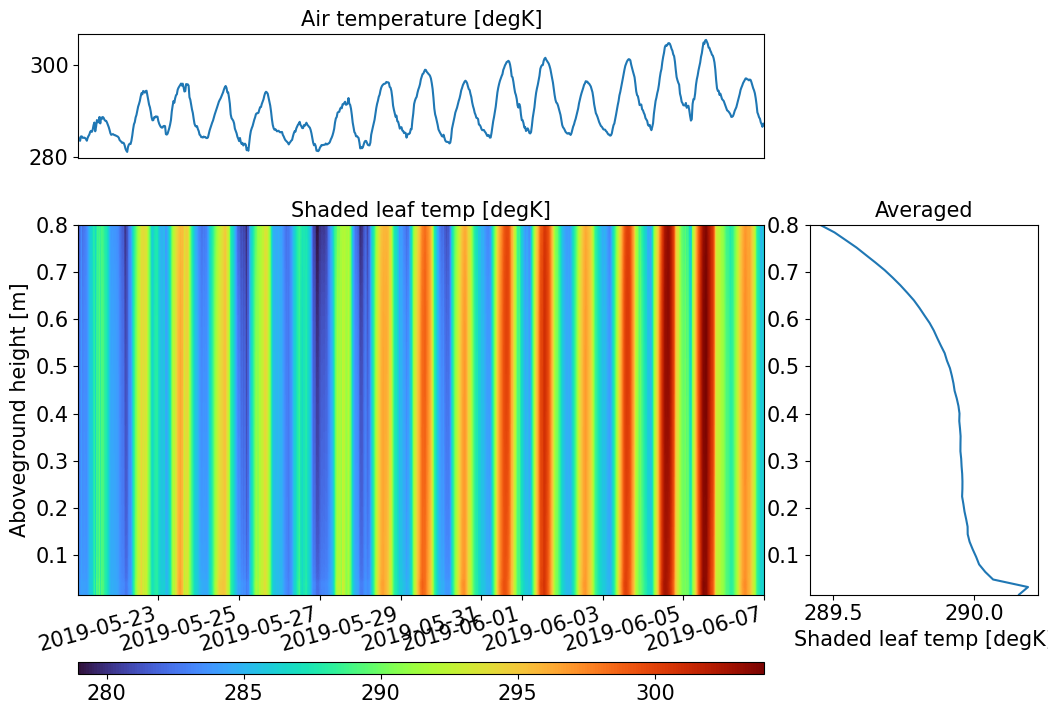

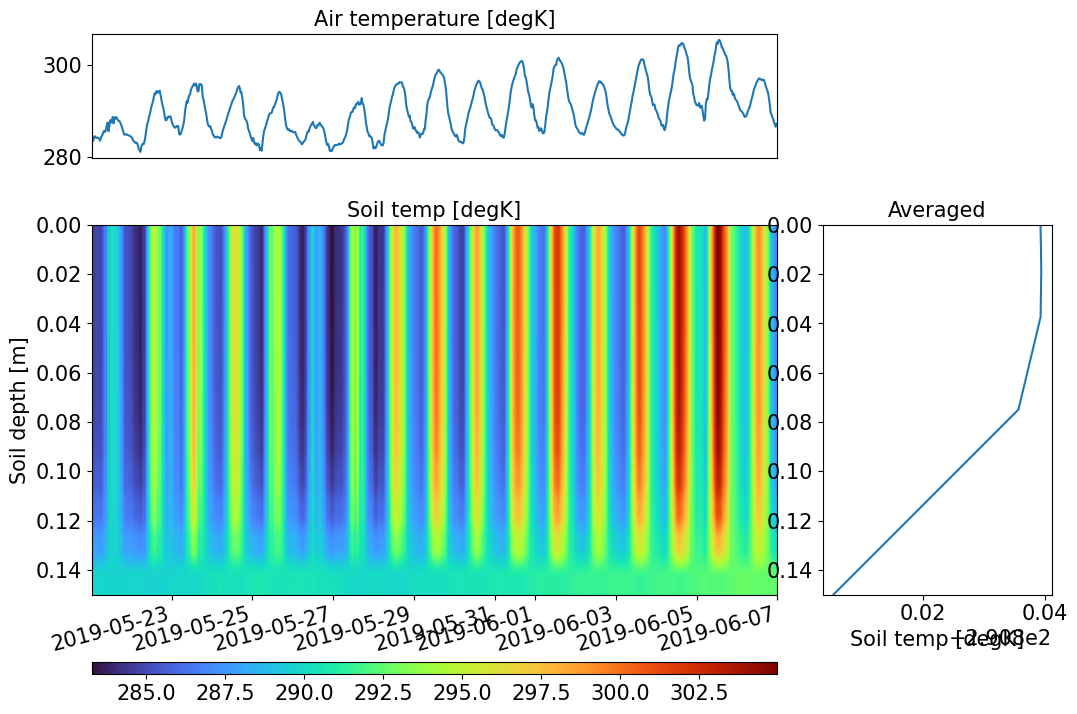

In [33]:
# Temperature
plot_imshow2(
    sun.Tsfc.T, met, para.zht1, key="T", title="Sunlit leaf temp [degk]", cmap="turbo"
)
plot_imshow2(
    shade.Tsfc.T, met, para.zht1, key="T", title="Shaded leaf temp [degK]", cmap="turbo"
)
plot_imshow2(
    soil.T_soil[:, :-1].T,
    met,
    soil.z_soil,
    key="T",
    title="Soil temp [degK]",
    cmap="turbo",
    is_canopy=False,
)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0), met.hhour)
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0), met.hhour)
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0), met.hhour)
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  # mean = compute_daily_average(array.mean(axis=0),

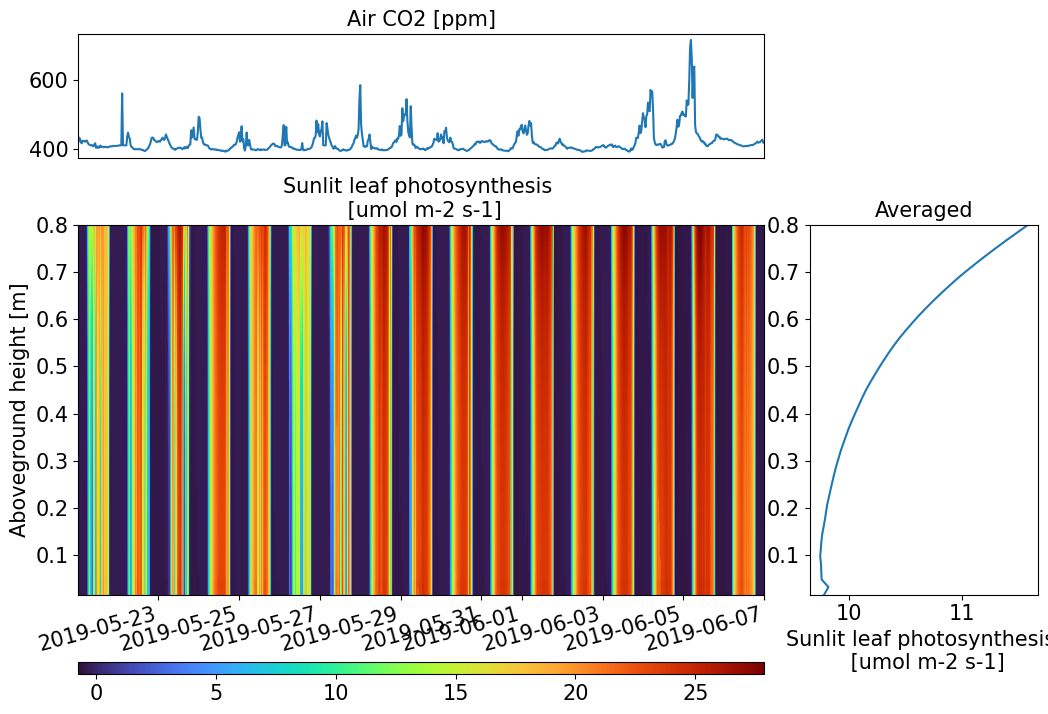

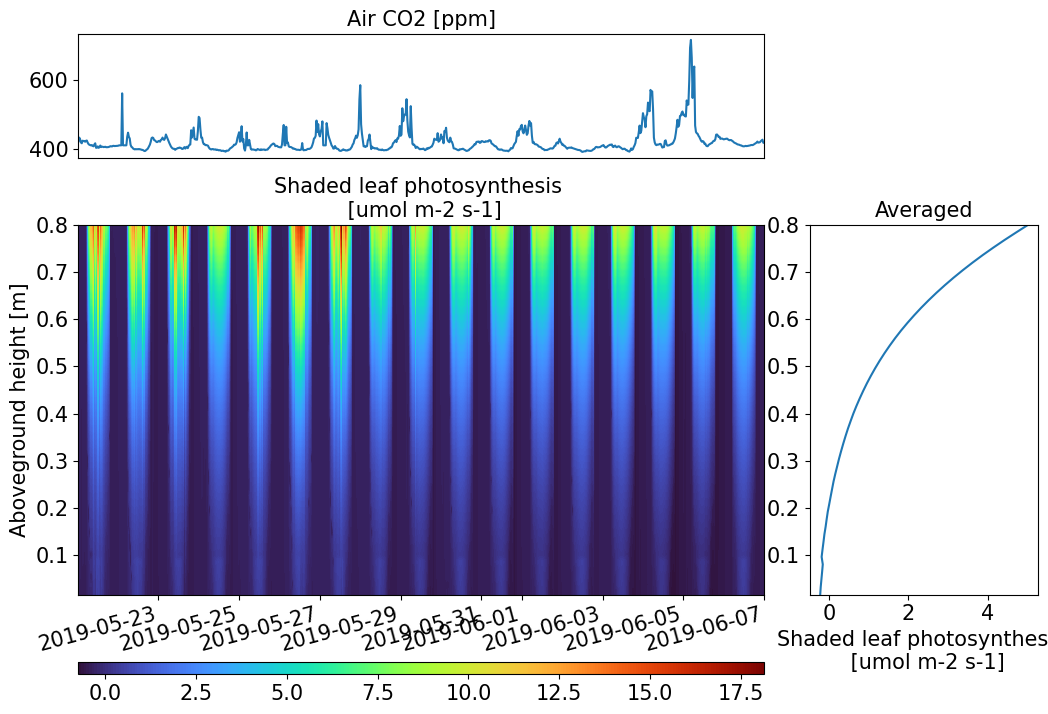

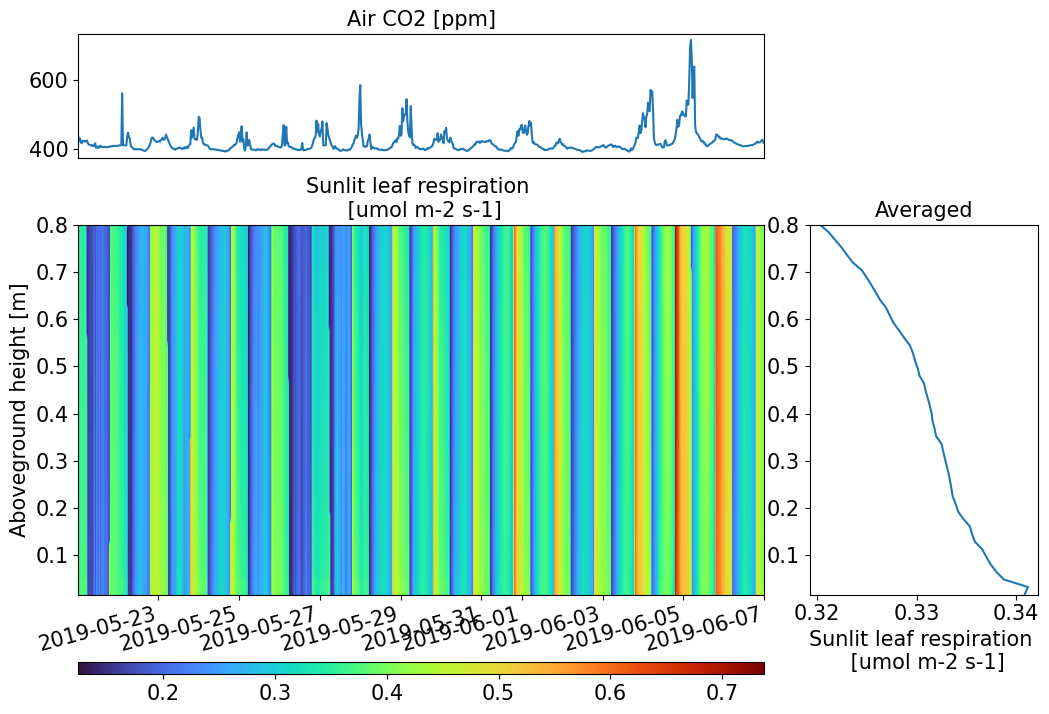

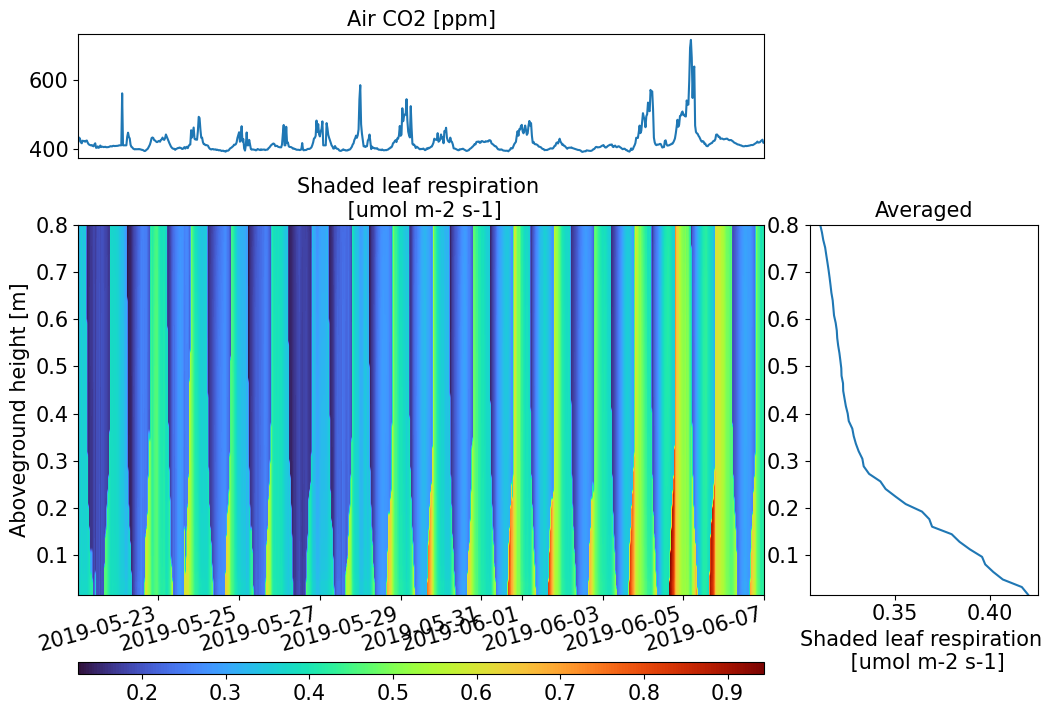

In [34]:
# respiration/photosynthesis
plot_imshow2(
    sun.Ps.T,
    met,
    para.zht1,
    key="co2",
    title="Sunlit leaf photosynthesis \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    shade.Ps.T,
    met,
    para.zht1,
    key="co2",
    title="Shaded leaf photosynthesis \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    sun.Resp.T,
    met,
    para.zht1,
    key="co2",
    title="Sunlit leaf respiration \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    shade.Resp.T,
    met,
    para.zht1,
    key="co2",
    title="Shaded leaf respiration \n [umol m-2 s-1]",
    cmap="turbo",
)

In [14]:
# met2 = jax.tree_util.tree_map(lambda x: x.reshape(1,816), met)
# jax.vmap(canoak, in_axes=[None,None,0,None,None,None])(para, setup, met2,
#    dij, setup.soil_mtime, setup.niter)

# Now, let's do some sensitivity analysis for fun!

## Forcings

The first try: how is the soil surface temperature sensitive to the atmospheric forcing?
To do that, we need to create a seperate jittable function that only outputs soil surface temperature.

The following leads to a dead kernel, mostly likely due to the OOM issue.

This is because we are using the forward mode which is not suitable
for cases with more inputs than outputs

In [ ]:
# @eqx.filter_jit
# @partial(jax.jacfwd, argnums=1)
# def canoak_soil_sfc(para, met, *args):
#     met, prof, ir, qin, sun, shade, soil, veg = canoak(
#         para, met, *args
#     )
#     return soil.sfc_temperature

# gradients = canoak_soil_sfc(para, met, *initials)

Let's try using the reverse mode.

We should NOT do this. Since it computes all the combinations of input and output.
A lot of the combinations are meaningless.

It takes more than 12 min ... Just stop!

In [18]:
# @partial(jax.jacrev, argnums=1)
# def canoak_soil_sfc2(para, met, *args):
#     met, prof, ir, qin, sun, shade, soil, veg = canoak(para, met, *args)
#     return soil.sfc_temperature


# gradients2 = canoak_soil_sfc2(para, met, *initials)

It works for just doing sensitivity on one output.

In [14]:
# @eqx.filter_jit
# @partial(jax.grad, argnums=1)
# def canoak_soil_sfc(para, met, *args):
#     met, prof, ir, qin, sun, shade, soil, veg = canoak(para, met, *args)
#     return soil.sfc_temperature[0]


# gradients = canoak_soil_sfc(para, met, *initials)

How about performing sensitivity on one input variable, Tair.
Too slow ...

In [14]:
# @eqx.filter_jit
# @partial(
#     jax.jacrev,
#     argnums=0,
# )
# def canoak_soil_sfc3(Tair, para, met, *args):
#     met = eqx.tree_at(lambda t: t.T_air, met, Tair)
#     met, prof, ir, qin, sun, shade, soil, veg = canoak(para, met, *args)
#     return soil.sfc_temperature


# gradients3 = canoak_soil_sfc3(met.T_air, para, met, *initials)

: 

## Parameters

The number of forcings are too many, causing the memory issues. Let's focus on the parameters now instead.

How about the sensitivity of the parameters to one output?
It takes ~ 1min to complete.

In [10]:
# @eqx.filter_jit
# @partial(jax.grad, argnums=0)
# def canoak_soil_sfc_para(para, setup, met, *args):
#     (
#         met,
#         prof,
#         quantum,
#         nir,
#         ir,
#         rnet,
#         qin,
#         sun_ang,
#         leaf_ang,
#         lai,
#         sun,
#         shade,
#         soil,
#         veg,
#         can,
#     ) = canoak(para, setup, met, *args)
#     return veg.Tsfc[0]


# gradients = canoak_soil_sfc_para(para, setup, met, *other_args)
# gradients.par_reflect

Array(0., dtype=float64, weak_type=True)

How about the sensitivity of the parameters to an array of outputs?
It takes ~ 7min. It's long, but reasonablly good.

In [11]:
# @eqx.filter_jit
# @partial(jax.jacrec, argnums=0)
# def canoak_soil_sfc_para2(para, setup, met, *args):
#     (
#         met,
#         prof,
#         quantum,
#         nir,
#         ir,
#         rnet,
#         qin,
#         sun_ang,
#         leaf_ang,
#         lai,
#         sun,
#         shade,
#         soil,
#         veg,
#         can,
#     ) = canoak(para, setup, met, *args)
#     return veg.Tsfc


# gradients2 = canoak_soil_sfc_para2(para, setup, met, *other_args)

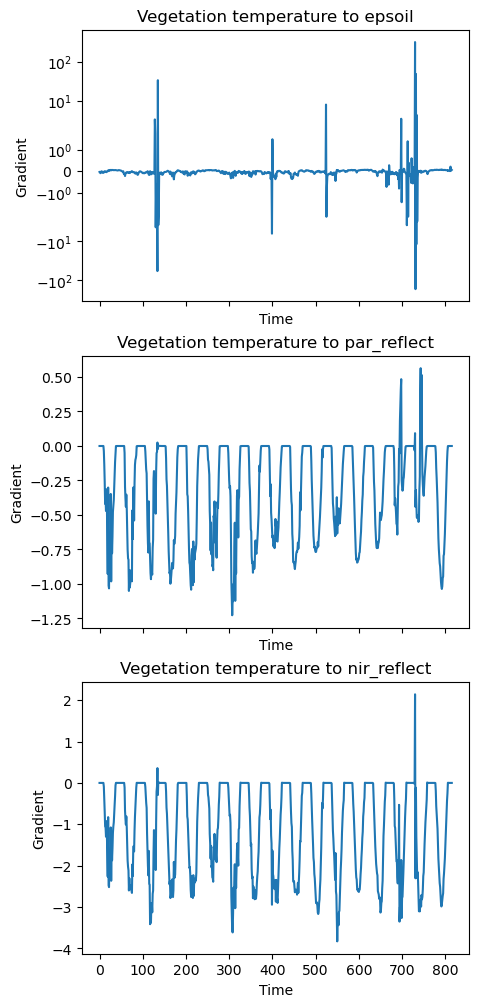

In [24]:
# fig, axes = plt.subplots(3, 1, figsize=(5, 12), sharex=True)
# ax = axes[0]
# ax.plot(gradients2.epsoil)
# ax.set(
#     yscale="symlog",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="Vegetation temperature to epsoil",
# )

# ax = axes[1]
# ax.plot(gradients2.par_reflect)
# ax.set(
#     yscale="linear",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="Vegetation temperature to par_reflect",
# )

# ax = axes[2]
# ax.plot(gradients2.nir_reflect)
# ax.set(
#     yscale="linear",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="Vegetation temperature to nir_reflect",
# );

How about outputing the whole veg pytree? Well, it takes ~8min. Not bad!

In [182]:
# # How about outputing the whole veg pytree?
# @eqx.filter_jit
# @partial(jax.jacfwd, argnums=0)
# def canoak_para(para, setup, met, *args):
#     (
#         met,
#         prof,
#         quantum,
#         nir,
#         ir,
#         rnet,
#         qin,
#         sun_ang,
#         leaf_ang,
#         lai,
#         sun,
#         shade,
#         soil,
#         veg,
#         can,
#     ) = canoak(para, setup, met, *args)
#     return can


# gradients3 = canoak_para(para, setup, met, *other_args)

[None,
 Text(0.5, 0, 'Time [day of year]'),
 Text(0, 0.5, 'Gradient'),
 Text(0.5, 1.0, 'Net radiation to par_reflect')]

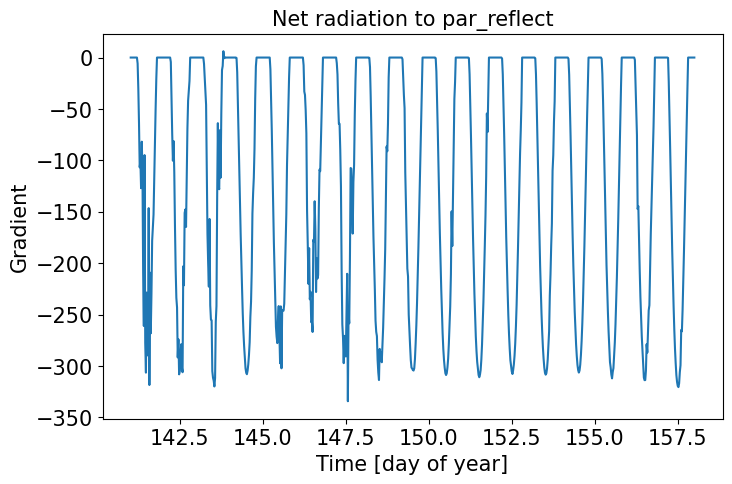

In [188]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True)

# ax.plot(met.day + met.hhour / 24, gradients3.rnet.par_reflect)
# ax.set(
#     yscale="linear",
#     xlabel="Time [day of year]",
#     ylabel="Gradient",
#     title="Net radiation to par_reflect",
# )

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True)
# ax = axes[0, 0]
# ax.plot(gradients3.Ps.epsoil)
# ax.set(
#     yscale="symlog",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="Vegetation photosynthesis to \n epsoil",
# )

# ax = axes[1, 0]
# ax.plot(gradients3.Ps.par_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="par_reflect")

# ax = axes[2, 0]
# ax.plot(gradients3.Ps.nir_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="nir_reflect")

# ax = axes[0, 1]
# ax.plot(gradients3.Tsfc.epsoil)
# ax.set(
#     yscale="symlog",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="Vegetation temperature to \n epsoil",
# )

# ax = axes[1, 1]
# ax.plot(gradients3.Tsfc.par_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="par_reflect")

# ax = axes[2, 1]
# ax.plot(gradients3.Tsfc.nir_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="nir_reflect")

# ax = axes[0, 2]
# ax.plot(gradients3.Rnet.epsoil)
# ax.set(
#     yscale="symlog",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="Vegetation net radiation to \n epsoil",
# )

# ax = axes[1, 2]
# ax.plot(gradients3.Rnet.par_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="par_reflect")

# ax = axes[2, 2]
# ax.plot(gradients3.Rnet.nir_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="nir_reflect");

In [21]:
# # How about outputing the whole veg pytree?
# @eqx.filter_jit
# @partial(jax.jacfwd, argnums=0)
# def canoak_para2(para, setup, met, *args):
#     (
#         met,
#         prof,
#         quantum,
#         nir,
#         ir,
#         rnet,
#         qin,
#         sun_ang,
#         leaf_ang,
#         lai,
#         sun,
#         shade,
#         soil,
#         veg,
#         can,
#     ) = canoak(para, setup, met, *args)
#     return can


# gradients4 = canoak_para2(para, setup, met, *other_args)

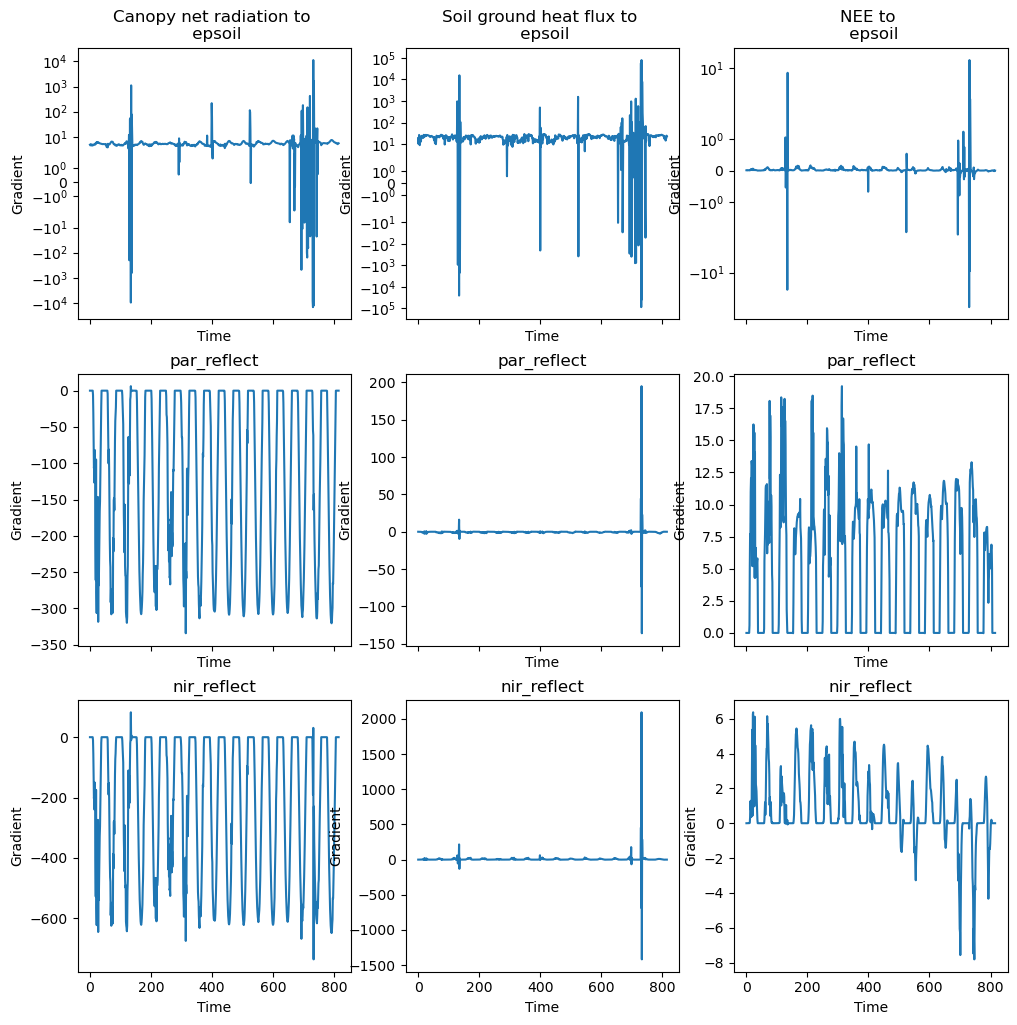

In [23]:
# fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True)
# ax = axes[0, 0]
# ax.plot(gradients4.rnet.epsoil)
# ax.set(
#     yscale="symlog",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="Canopy net radiation to \n epsoil",
# )

# ax = axes[1, 0]
# ax.plot(gradients4.rnet.par_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="par_reflect")

# ax = axes[2, 0]
# ax.plot(gradients4.rnet.nir_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="nir_reflect")

# ax = axes[0, 1]
# ax.plot(gradients4.gsoil.epsoil)
# ax.set(
#     yscale="symlog",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="Soil ground heat flux to \n epsoil",
# )

# ax = axes[1, 1]
# ax.plot(gradients4.gsoil.par_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="par_reflect")

# ax = axes[2, 1]
# ax.plot(gradients4.gsoil.nir_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="nir_reflect")

# ax = axes[0, 2]
# ax.plot(gradients4.NEE.epsoil)
# ax.set(
#     yscale="symlog",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="NEE to \n epsoil",
# )

# ax = axes[1, 2]
# ax.plot(gradients4.NEE.par_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="par_reflect")

# ax = axes[2, 2]
# ax.plot(gradients4.NEE.nir_reflect)
# ax.set(yscale="linear", xlabel="Time", ylabel="Gradient", title="nir_reflect");

The veg pytree only contains the averged profiles.
Can we do sensitivity on multiple layer temperature?


OK, that's too much for my laptop (the kernel is dead!)

In [37]:
# @eqx.filter_jit
# @partial(jax.jacrev, argnums=0)
# def canoak_soil_sfc_para4(para, setup, met, *args):
#     (
#         met,
#         prof,
#         quantum,
#         nir,
#         ir,
#         rnet,
#         qin,
#         sun_ang,
#         leaf_ang,
#         lai,
#         sun,
#         shade,
#         soil,
#         veg,
#     ) = canoak(para, setup, met, *args)
#     tsfc = (
#         quantum.prob_beam[:, :-1] * sun.Tsfc + quantum.prob_shade[:, :-1] * shade.Tsfc
#     )
#     return tsfc


# gradients4 = canoak_soil_sfc_para4(para, setup, met, *other_args)

: 

: 

OK, good. Can we further reduce the computing time by narrowing down the parameters of interests?

Let's try using eqx filter to define the parameters to be estimated.

It also took ~5min to complete. No speedup.
However, the gradients are also applied to static_para.
How to avoid that?

In [19]:
# filter_spec = jtu.tree_map(lambda _: False, para)
# filter_spec = eqx.tree_at(
#     lambda t: (t.leaf_clumping_factor, t.par_reflect, t.epsoil),
#     filter_spec,
#     replace=(True, True, True),
# )
# diff_para, static_para = eqx.partition(para, filter_spec)
# para_eqx = eqx.combine(diff_para, static_para)

# gradients3 = canoak_soil_sfc_para(para_eqx, setup, met, *initials)

[None,
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Gradient'),
 Text(0.5, 1.0, 'Soil surface temperature to epsoil')]

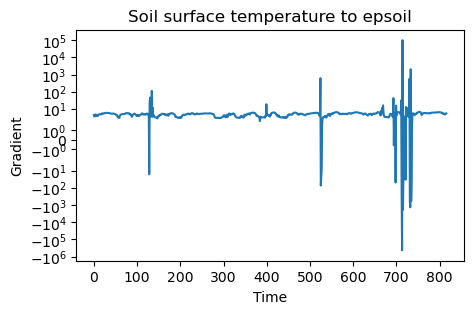

In [33]:
# # The result is consistent, though
# fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# ax.plot(gradients3.epsoil)
# ax.set(
#     yscale="symlog",
#     xlabel="Time",
#     ylabel="Gradient",
#     title="Soil surface temperature to epsoil",
# )